# Install TensorFlow Object Detection API

Pip may report some dependency errors. You can safely ignore these errors and proceed if all tests in `model_builder_tf2_test.py` passed. 

In [2]:
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
Found existing installation: keras 2.7.0
Uninstalling keras-2.7.0:
  Successfully uninstalled keras-2.7.0


In [ ]:
#!git clone https://github.com/tensorflow/models

In [3]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
!mv builder.py /home/jovyan/.local/lib/python3.9/site-packages/google/protobuf/internal/

--2022-12-14 09:51:29--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5188 (5.1K) [text/plain]
Saving to: ‘builder.py’

builder.py          100%[===================>]   5.07K  --.-KB/s    in 0s      

2022-12-14 09:51:29 (35.2 MB/s) - ‘builder.py’ saved [5188/5188]



In [4]:
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
# Note: I fixed the version of some dependencies to make it work on Kaggle notebook. In particular:
# * scipy==1.6.3 to avoid the missing GLIBCXX_3.4.26 error
# * tensorflow to 2.6.0 to make it compatible with the CUDA version preinstalled on Kaggle.
# When Kaggle notebook upgrade to TF 2.7, you can use the default setup.py script:
# cp object_detection/packages/tf2/setup.py .
#!wget https://storage.googleapis.com/odml-dataset/others/setup.py
!pip install -q --user .

# Test if the Object Dectection API is working correctly
!python3 object_detection/builders/model_builder_tf2_test.py

/home/jovyan/top-down-object-detection/models/research
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.4.3 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.
/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: 

# Import dependencies

In [5]:
import contextlib2
import io
import IPython
import json
import numpy as np
import os
import pathlib
import pandas as pd
import sys
import tensorflow as tf
import time

from PIL import Image, ImageDraw

In [6]:
# The notebook is supposed to run with TF 2.6.0
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-14 09:54:18.570519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 09:54:19.159482: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-14 09:54:19.159529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 10419 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


# Train an object detection model

### **Model selection**

One of the coolest features of the TensorFlow Object Detection API is the opportunity to work with a set of state of the art models, pre-trained on the COCO dataset! We can fine-tune these models for our purposes and get great results.

We'll use [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) and an EfficientDet-D4 model and apply transfer learning to train a COTS detection model. You can probably increase accuracy by switch to using a larger EfficientDet model.

In [ ]:
#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
#!tar -xvzf efficientdet_d2_coco17_tpu-32.tar.gz

In [7]:
%cd object_detection

/home/jovyan/top-down-object-detection/models/research/object_detection


In [ ]:
#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
#!tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz

### **Model configuration**
We downloaded and extracted a pre-trained model of our choice. Now we want to configure it.

**Model configuration** is a process that lets us tailor model-related artifacts (e.g. hyperparameters, loss function, etc) so that it can be trained (fine-tuned) to tackle detection for the objects that we’re interested in. That’s it.

The TensorFlow Object Detection API allows model configuration via the **pipeline.config** file that goes along with the pre-trained model. 

In [9]:
from string import Template

config_file_template = """
model {
  ssd {
    num_classes: 3
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: "ssd_efficientnet-b0_bifpn_keras"
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: SWISH
        batch_norm {
          decay: 0.9900000095367432
          scale: true
          epsilon: 0.0010000000474974513
        }
        force_use_bias: true
      }
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 1.0
        x_scale: 1.0
        height_scale: 1.0
        width_scale: 1.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 3.9999998989515007e-05
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.009999999776482582
            }
          }
          activation: SWISH
          batch_norm {
            decay: 0.9900000095367432
            scale: true
            epsilon: 0.0010000000474974513
          }
          force_use_bias: true
        }
        depth: 64
        num_layers_before_predictor: 3
        kernel_size: 3
        class_prediction_bias_init: -4.599999904632568
        use_depthwise: true
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 3
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 9.99999993922529e-09
        iou_threshold: 0.5
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 1.5
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    add_background_class: false
  }
}
train_config {
  batch_size: 4
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_scale_crop_and_pad_to_square {
      output_size: 512
      scale_min: 0.10000000149011612
      scale_max: 2.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.001
          total_steps: 3000
          warmup_learning_rate: 0.0010000000474974513
          warmup_steps: 200
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"
  num_steps: 3000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection"
  use_bfloat16: true
  fine_tune_checkpoint_version: V2
}
train_input_reader: {
  label_map_path: "data/label_map.txt"
  tf_record_input_reader {
    input_path: "data/train.record"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 1;
}

eval_input_reader: {
  label_map_path: "data/label_map.txt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "data/test.record"
  }
}
"""

In [ ]:
#!wget https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py -P scripts/

In [ ]:
# Generate TF Records
#!python {'scripts/generate_tfrecord.py'} -x {'images/train'} -l {'data/label_map.txt'} -o {'data/train.record'}
#!python {'scripts/generate_tfrecord.py'} -x {'images/test'} -l {'data/label_map.txt'} -o {'data/test.record'}

In [12]:
# Define the training pipeline
TRAINING_STEPS = 3000
WARMUP_STEPS = 200
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 4
FINE_TUNE_CHECKPOINT = "efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"
LEARNING_RATE_BASE = 0.001
PIPELINE_CONFIG_PATH='data/pipeline.config'

pipeline = Template(config_file_template).substitute(
    training_steps=TRAINING_STEPS, 
    warmup_steps=WARMUP_STEPS, 
    learning_rate_base=LEARNING_RATE_BASE, 
    num_classes=NUM_CLASSES, 
    fine_tune_checkpoint = FINE_TUNE_CHECKPOINT,
    train_batch_size = TRAIN_BATCH_SIZE

)

with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

In [ ]:
# !rm -rf images/train/ images/test/

In [ ]:
#!mv ../data/ .
#!cp ../data/* data
#!mv ../images/ .

In [ ]:
#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
#!tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz

In [13]:
# Make sure to be in the /object_detection/ directory and that the model (i.e. efficientdet_d0...) has been loaded here
MODEL_DIR='efficientdet_d2'
!mkdir {MODEL_DIR}
!python3 model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr

mkdir: cannot create directory ‘efficientdet_d2’: File exists
/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefin

# Evaluate the object detection model

In [ ]:
rm -rf ../efficientdet_d0_coco17_tpu-32.tar.gz ../efficientdet_d0_coco17_tpu-32/ ../efficientdet_d2/

In [14]:
print("k")

k


In [16]:
!python model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --checkpoint_dir={MODEL_DIR} \
    --eval_timeout=0 \
    --alsologtostderr

/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase3GetEPNS_15OpKern

# Export as SavedModel for inference

In [17]:
!python exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir={MODEL_DIR} \
    --output_directory={MODEL_DIR}/output

/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/home/jovyan/.local/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase3GetEPNS_15OpKern

In [18]:
!ls {MODEL_DIR}/output

checkpoint  pipeline.config  saved_model


# Run inference on test images and create the submission file

In [19]:
# Load the TensorFlow COTS detection model into memory.
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn_tf_odt = tf.saved_model.load(os.path.join(MODEL_DIR, 'output', 'saved_model'))
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

2022-12-14 10:18:17.196392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10419 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


Elapsed time: 19.86253547668457s


In [40]:
import cv2

# Define some utils method for prediction.

def load_image(path):
    byte_img = cv2.imread(path)
    #byte_img = cv2.resize(byte_img, (640, 640))
    rgb = cv2.cvtColor(byte_img, cv2.COLOR_BGR2RGB)
    
    return tf.convert_to_tensor(rgb, dtype=tf.uint8)


def detect(image_np):
    input_tensor = np.expand_dims(image_np, 0)
    start_time = time.time()
    detections = detect_fn_tf_odt(input_tensor)
    return detections

In [84]:
image = load_image(os.path.join('images', 'test', 'c609b05a-7089-11ed-b2e3-1b1b14efb1a9.png'))

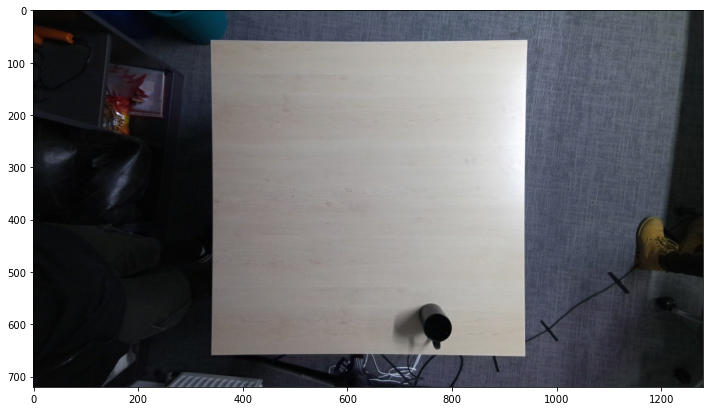

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.show()

0.8335838 cup
733 565 797 651


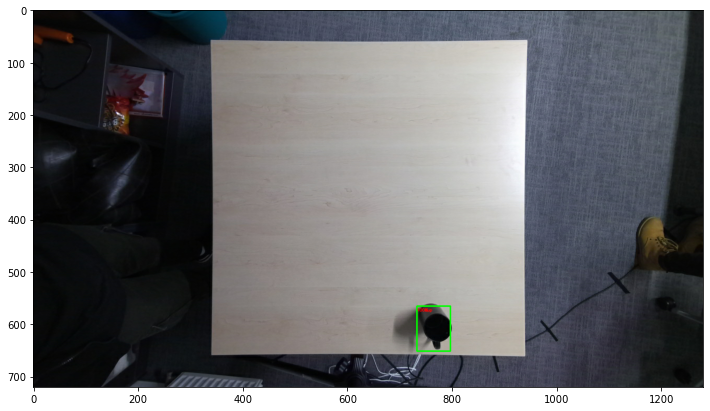

In [89]:
DETECTION_THRESHOLD = 0.3

labels = {"1": "bowl", "2": "cup", "3": "bottle"}

height, width, _ = image.shape

# Run object detection using the TensorFlow model.
detections = detect(image)

boxes, scores, classes, num_detections  = detections['detection_boxes'], detections['detection_scores'], detections['detection_classes'], detections['num_detections']
pred_labels = classes.numpy().astype('int')[0]
pred_labels = [labels[str(i)] for i in pred_labels]
pred_boxes = boxes.numpy()[0]
pred_scores = scores.numpy()[0]

# Parse the detection result and generate a prediction string.
num_detections = detections['num_detections'][0].numpy().astype(np.int32)

for score, (ymin, xmin, ymax, xmax), label in zip(pred_scores, pred_boxes, pred_labels):
    
    if score < 0.7:
        continue
    print(score, label)
    xmin = int(xmin * width)
    ymin = int(ymin * height)
    xmax = int(xmax * width)
    ymax = int(ymax * height)
    
    print(xmin, ymin, xmax, ymax)
    img_boxes = cv2.rectangle(np.array(image), (xmin, ymin), (xmax,ymax), (0,255,0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_boxes, label, (xmin + 15, ymin+10), font, 0.25, (255, 0, 0), 1, cv2.LINE_AA )
    score_txt = f"{100 * round(score)}%"
    cv2.putText(img_boxes, score_txt, (xmin, ymin+10), font, 0.25, (255, 0, 0), 1, cv2.LINE_AA )
    
plt.figure(figsize=(12,8))
plt.imshow(img_boxes)
plt.show()